In [94]:
import sys, os
import h5py
import numpy as np
from datetime import datetime

from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.optimizers import SGD

import matplotlib.pyplot as plt


In [95]:
basedir = '/home/jcx9dy/proj/cs6501/mass/benignvsmalign'
train_data_dir = basedir+'/train'
validation_data_dir = basedir+'/validate'
os.makedirs(basedir+'/report/figures', exist_ok=True)

nb_train_samples = 1881
nb_train_class0 = 903         #benign
nb_train_class1 = 978         #malignant
nb_validation_samples = 481
nb_validation_class0 = 238    #benign
nb_validation_class1 = 243    #malignant

nb_worker = 8  #cpus for real-time image augmentation
batch_size = 32


#only rescaling by 16bit value range or original picture
datagen = ImageDataGenerator(rescale=1.0/65535)

#validation_generator.directory
#validation_generator.filenames
#validation_generator.classes
#X=datagen.standardize(img_to_array(load_img(path)))

# Deep Model

In [97]:
### Load InceptionV3

img_width, img_height = 299, 299  # target size of input (resizes pictures to this)

from keras.models import model_from_json
json_file = open(basedir+'/output/models/InceptionV3_adapted.json', 'r')
json_string = json_file.read()
json_file.close()
model2 = model_from_json(json_string)
model2.load_weights(basedir+'/output/checkpoints/20161204_065740-InceptionV3_train172on-008-0.783.hdf5')
model2.compile(optimizer=SGD(lr=.001, decay=0.0002, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


### Evaluate current model accuracy

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical', 
        color_mode='rgb')
validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        color_mode='rgb')

print('Evaluating training data... ')
print(model2.metrics_names)
inception_train_acc = model2.evaluate_generator(
        train_generator,
        val_samples=nb_train_samples,
        nb_worker=nb_worker,
        pickle_safe=True)
print(inception_train_acc)

print('Evaluating validation data... ')
print(model2.metrics_names)
inception_val_acc = model2.evaluate_generator(
        validation_generator,
        val_samples=nb_validation_samples,
        nb_worker=nb_worker,
        pickle_safe=True)
print(inception_val_acc)




Found 1881 images belonging to 2 classes.
Found 481 images belonging to 2 classes.
Evaluating training data... 
['loss', 'acc']
[0.24688780913918706, 0.89247881355932202]
Evaluating validation data... 
['loss', 'acc']
[0.43673722445964813, 0.828125]


In [123]:
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 149, 149, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 149, 149, 32)  128         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 147, 147, 32)  9248        batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [98]:
### Generate and save predictions 

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        color_mode='rgb')
validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        color_mode='rgb')

print('Generating predictions from training data... ')
deep_train_pred = model2.predict_generator(
        train_generator,
        val_samples=nb_train_samples,
        nb_worker=1, #increasing this fails with reshaping
        pickle_safe=True)

print('Generating predictions from validation data... ')
deep_val_pred = model2.predict_generator(
        validation_generator,
        val_samples=nb_validation_samples,
        nb_worker=1,
        pickle_safe=True)

#reshape truth to match prediction array
deep_train_truth = np.array(train_generator.classes).reshape((nb_train_samples,1))
deep_val_truth = np.array(validation_generator.classes).reshape((nb_validation_samples,1))

#also convert categorical 2 class to binary, via softmax
deep_train_pred_collapsed = np.zeros(nb_train_samples)
for i in range(nb_train_samples):
    deep_train_pred_collapsed[i] = deep_train_pred[i][1] / np.sum(deep_train_pred[i])
deep_train_pred_collapsed = deep_train_pred_collapsed.reshape((nb_train_samples, 1))

deep_val_pred_collapsed = np.zeros(nb_validation_samples)
for i in range(nb_validation_samples):
    deep_val_pred_collapsed[i] = deep_val_pred[i][1] / np.sum(deep_val_pred[i])
deep_val_pred_collapsed = deep_val_pred_collapsed.reshape((nb_validation_samples, 1))

Found 1881 images belonging to 2 classes.
Found 481 images belonging to 2 classes.
Generating predictions from training data... 
Generating predictions from validation data... 


In [122]:
### Quick and dirty way of analyzing images: append probability to file name, let filesystem sort automatically

for i, fname in enumerate(validation_generator.filenames):

    isModelGrayscale = False
    malignancyprob = deep_val_pred_collapsed[i][0]
    
    prefix =  '{0:.4f}'.format(malignancyprob)
    imgpath = validation_generator.directory + '/' + fname
    classname, imgname = os.path.split(fname)
    savepath = basedir + '/report/predictions/inceptionv3/validation/' + classname +'/' + prefix + '-' + imgname
    parent, _ = os.path.split(savepath)
    os.makedirs(parent, exist_ok=True)
    
    foo = img_to_array(load_img(imgpath, grayscale=isModelGrayscale, target_size=(img_width, img_height)))
    foo *= 1.0/65535
    img = array_to_img(foo)
    img.save(savepath)


In [134]:
### Confusion matrix (rows are truth, columns are predicted)

from sklearn.metrics import confusion_matrix
ytrue = np.ndarray.flatten(deep_val_truth)
ypred = np.round(np.ndarray.flatten(deep_val_pred_collapsed))

cm_deep = confusion_matrix(ytrue, ypred)
cm_deep

array([[207,  31],
       [ 88, 155]])

# Shallow Model

In [125]:
##### Load Shallow 3 convolution model

img_width, img_height = 96, 96  # target size of input (resizes pictures to this)

from keras.models import model_from_json
json_file = open(basedir+'/output/models/20161202_023752-chollet_blog.json', 'r')
json_string = json_file.read()
json_file.close()
model1 = model_from_json(json_string)
model1.load_weights(basedir+'/output/checkpoints/20161202_023752-chollet_blog-331-0.746.hdf5')
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### Evaluate current model accuracy

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary', 
        color_mode='grayscale')
validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary',
        color_mode='grayscale')

print('Evaluating training data... ')
print(model1.metrics_names)
shallow_train_acc = model1.evaluate_generator(
        train_generator,
        val_samples=nb_train_samples,
        nb_worker=nb_worker,
        pickle_safe=True)
print(shallow_train_acc)

print('Evaluating validation data... ')
print(model1.metrics_names)
shallow_val_acc = model1.evaluate_generator(
        validation_generator,
        val_samples=nb_validation_samples,
        nb_worker=nb_worker,
        pickle_safe=True)
print(shallow_val_acc)

Found 1881 images belonging to 2 classes.
Found 481 images belonging to 2 classes.
Evaluating training data... 
['loss', 'acc']
[0.57276701523085771, 0.72669491525423724]
Evaluating validation data... 
['loss', 'acc']
[0.58316284418106079, 0.734375]


In [126]:
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 98, 98, 1)     0           zeropadding2d_input_3[0][0]      
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 96, 96, 32)    320         zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 96, 96, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 48, 48, 32)    0           activation_1[0][0]               
___________________________________________________________________________________________

In [23]:
### Generate and save predictions 

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        color_mode='grayscale')
validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        color_mode='grayscale')
#validation_generator.directory
#validation_generator.filenames
#validation_generator.classes

print('Generating predictions from training data... ')
shallow_train_pred = model1.predict_generator(
        train_generator,
        val_samples=nb_train_samples,
        nb_worker=1, #increasing this fails with reshaping
        pickle_safe=True)

print('Generating predictions from validation data... ')
shallow_val_pred = model1.predict_generator(
        validation_generator,
        val_samples=nb_validation_samples,
        nb_worker=1,
        pickle_safe=True)

#reshape truth to match prediction array
shallow_train_truth = np.array(train_generator.classes).reshape((nb_train_samples,1))
shallow_val_truth = np.array(validation_generator.classes).reshape((nb_validation_samples,1))


Found 1881 images belonging to 2 classes.
Found 481 images belonging to 2 classes.


In [89]:
### Quick and dirty way of analyzing images: append probability to file name, let filesystem sort automatically

for i, fname in enumerate(validation_generator.filenames):

    isModelGrayscale = True
    malignancyprob = shallow_val_pred[i][0]
    
    prefix =  '{0:.4f}'.format(malignancyprob)
    imgpath = validation_generator.directory + '/' + fname
    classname, imgname = os.path.split(fname)
    savepath = basedir + '/report/predictions/shallow/validation/' + classname +'/' + prefix + '-' + imgname
    parent, _ = os.path.split(savepath)
    os.makedirs(parent, exist_ok=True)
    
    foo = img_to_array(load_img(imgpath, grayscale=isModelGrayscale, target_size=(img_width, img_height)))
    foo *= 1.0/65535
    img = array_to_img(foo)
    img.save(savepath)


In [133]:
### Confusion matrix (rows are truth, columns are predicted)

from sklearn.metrics import confusion_matrix
ytrue = np.ndarray.flatten(shallow_val_truth)
ypred = np.round(np.ndarray.flatten(shallow_val_pred))

cm_shallow = confusion_matrix(ytrue, ypred)
cm_shallow

array([[173,  65],
       [ 82, 161]])

# Confusion matrix

In [135]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[173  65]
 [ 82 161]]
Normalized confusion matrix
[[ 0.73  0.27]
 [ 0.34  0.66]]


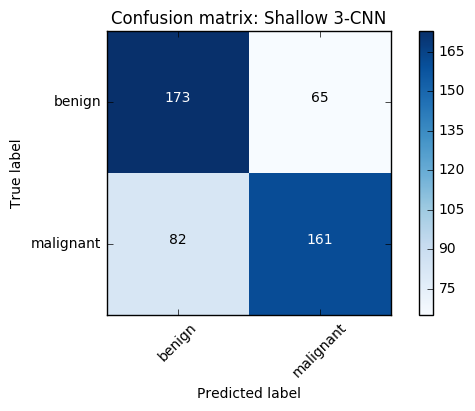

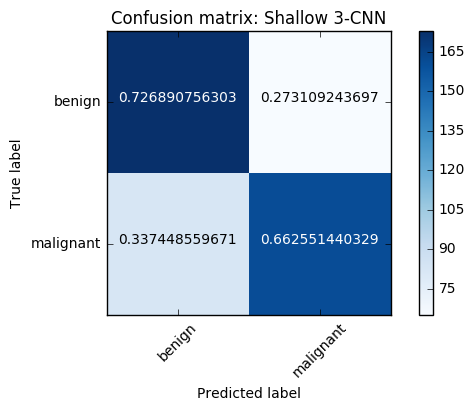

In [144]:
np.set_printoptions(precision=2)

cnf_matrix = cm_shallow
class_names = np.array(['benign', 'malignant'])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix: Shallow 3-CNN')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix: Shallow 3-CNN')

plt.show()

Confusion matrix, without normalization
[[207  31]
 [ 88 155]]
Normalized confusion matrix
[[ 0.87  0.13]
 [ 0.36  0.64]]


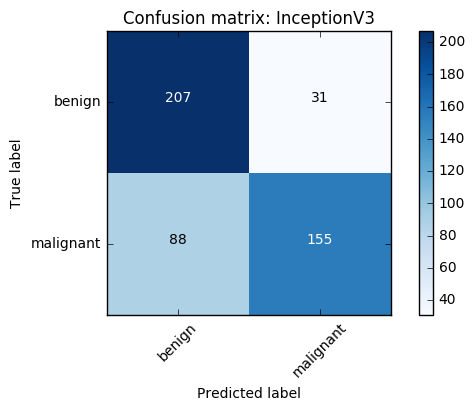

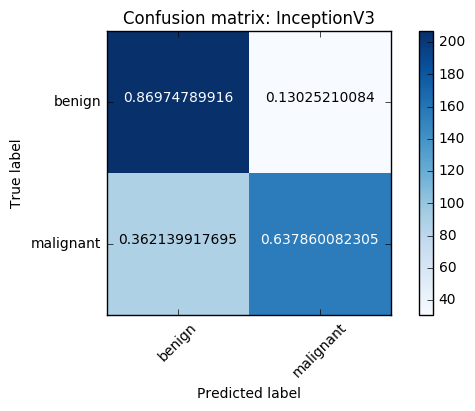

In [145]:
np.set_printoptions(precision=2)

cnf_matrix = cm_deep
class_names = np.array(['benign', 'malignant'])

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix: InceptionV3')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix: InceptionV3')

plt.show()

In [ ]:
#### Fancy code to group, sort, etc and plot/view images

# rank benign set by prediction
class0_argsort_indices = np.argsort(shallow_val_pred[:nb_validation_class0], axis=0)

# rank malignant set by prediction 
class1_argsort_indices = np.argsort(shallow_val_pred[nb_validation_class0:], axis=0) + nb_validation_class0